***
***

# Hits算法
***
***



Jon Kleinberg于1999年在Journal of the ACM发表题为Authoritative sources in a hyperlinked environment的文章。

对于一个网络G：

- Certain pages are valuable because they provide information about a topic. These pages are called **authorities**, a.
- Other pages are valuable because they tell you where to go to find out about that topic. These pages are called **hubs**, h.

“a page is a good hub if it links to good authorities, and a page is a good authority if it is linked to by good hubs.”

Hits算法通过迭代的方法来计算权威度a和导航度h。其中：

- 节点i的权威度aiai利用指向它的节点的在上一轮的导航度hlast和链接的权重来决定。 a=μLh
- 节点i的导航度hihi利用指向它指向的节点在这一轮的权威度aiai和链接的权重来决定。h=λLa

> An important observation is that dead ends or spider traps do not prevent the HITS iteration from converging to a meaningful pair of vectors. Thus, we can work with dead ends or spider traps directly, with no “taxation” or alteration of the graph needed.

In [79]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [3]:
G = nx.DiGraph()
G.add_edge(1, 2, weight = 50)
G.add_edge(1, 3, weight = 30)
G.add_edge(3, 2, weight = 10)
G.add_edge(2, 4, weight = 20)
G.add_edge(2, 5, weight = 30)
G.add_edge(5, 3, weight = 5)
G.add_edge(4, 5, weight = 10)

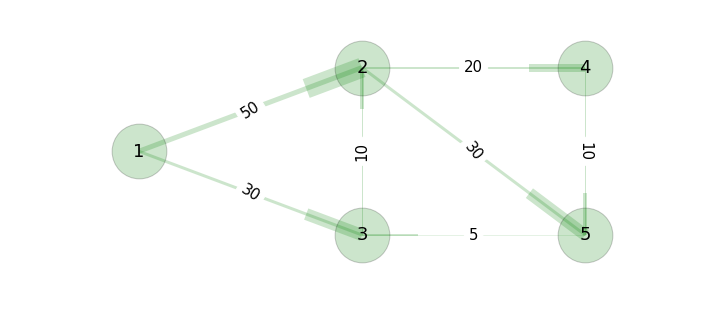

In [4]:
fig = plt.figure(figsize=(12, 5),facecolor='white')     
pos={1: np.array([ 0.2,  0.5]),
 2: np.array([ 0.4,  0.8]),
 3: np.array([ 0.4,  0.2 ]),
 4: np.array([ 0.6,  0.8]),
 5: np.array([ 0.6,  0.2])}

width=[float(d['weight']*.1) for (u,v,d) in G.edges(data=True)]
edge_labels=dict([((u,v,),d['weight']) for u,v,d in G.edges(data=True)])
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels, font_size = 15,alpha = .5)
nx.draw(G, pos, node_size = 3000, node_color = 'green', 
        alpha = 0.2, width = width, edge_color='green',style='solid')
nx.draw_networkx_labels(G,pos,font_size=18)
plt.show() 

在networkx里，我们可以调用hits函数来采用迭代的方式实现hits算法。



In [64]:
# http://networkx.readthedocs.io/en/stable/_modules/networkx/algorithms/link_analysis/hits_alg.html#hits
    
def hits(G,max_iter=100,tol=1.0e-8,nstart=None,normalized=True):
    """Return HITS hubs and authorities values for nodes.

    The HITS algorithm computes two numbers for a node.
    Authorities estimates the node value based on the incoming links.
    Hubs estimates the node value based on outgoing links.

    Parameters
    ----------
    G : graph
      A NetworkX graph

    max_iter : interger, optional
      Maximum number of iterations in power method.

    tol : float, optional
      Error tolerance used to check convergence in power method iteration.

    nstart : dictionary, optional
      Starting value of each node for power method iteration.

    normalized : bool (default=True)
       Normalize results by the sum of all of the values.

    Returns
    -------
    (hubs,authorities) : two-tuple of dictionaries
       Two dictionaries keyed by node containing the hub and authority
       values.

    Examples
    --------
    >>> G=nx.path_graph(4)
    >>> h,a=nx.hits(G)

    Notes
    -----
    The eigenvector calculation is done by the power iteration method
    and has no guarantee of convergence.  The iteration will stop
    after max_iter iterations or an error tolerance of
    number_of_nodes(G)*tol has been reached.

    The HITS algorithm was designed for directed graphs but this
    algorithm does not check if the input graph is directed and will
    execute on undirected graphs.

    References
    ----------
    .. [1] A. Langville and C. Meyer,
       "A survey of eigenvector methods of web information retrieval."
       http://citeseer.ist.psu.edu/713792.html
    .. [2] Jon Kleinberg,
       Authoritative sources in a hyperlinked environment
       Journal of the ACM 46 (5): 604-32, 1999.
       doi:10.1145/324133.324140.
       http://www.cs.cornell.edu/home/kleinber/auth.pdf.
    """
    if type(G) == nx.MultiGraph or type(G) == nx.MultiDiGraph:
        raise Exception("hits() not defined for graphs with multiedges.")
    if len(G) == 0:
        return {},{}
    # choose fixed starting vector if not given
    if nstart is None:
        h=dict.fromkeys(G,1.0/G.number_of_nodes())
    else:
        h=nstart
        # normalize starting vector
        s=1.0/sum(h.values())
        for k in h:
            h[k]*=s
    i=0
    while True: # power iteration: make up to max_iter iterations
        hlast=h
        h=dict.fromkeys(hlast.keys(),0)
        a=dict.fromkeys(hlast.keys(),0)
        # this "matrix multiply" looks odd because it is
        # doing a left multiply a^T=hlast^T*G
        for n in h:
            for nbr in G[n]:
                a[nbr]+=hlast[n]*G[n][nbr].get('weight',1)
        # now multiply h=Ga
        for n in h:
            for nbr in G[n]:
                h[n]+=a[nbr]*G[n][nbr].get('weight',1)
        # normalize vector
        s=1.0/max(h.values())
        for n in h: h[n]*=s
        # normalize vector
        s=1.0/max(a.values())
        for n in a: a[n]*=s
        # check convergence, l1 norm
        err=sum([abs(h[n]-hlast[n]) for n in h])
        if err < tol:
            break
        if i>max_iter:
            raise NetworkXError(\
            "HITS: power iteration failed to converge in %d iterations."%(i+1))
        i+=1
    if normalized:
        s = 1.0/sum(a.values())
        for n in a:
            a[n] *= s
        s = 1.0/sum(h.values())
        for n in h:
            h[n] *= s
    return h,a

首先，hits算法是从导航页面投票给权威页面。

如果不指定，初始的导航度hub取值都一样。

如上图共有五个节点，每一个节点的hub初始值为0.2。

In [50]:
# choose fixed starting vector if not given
nstart = None
if nstart is None:
    h=dict.fromkeys(G,1.0/G.number_of_nodes())  
else: 
    h=nstart
    # normalize starting vector
    s=1.0/sum(h.values())
    for k in h:
        h[k]*=s
        
h

{1: 0.2, 2: 0.2, 3: 0.2, 4: 0.2, 5: 0.2}

然后，我们通过迭代的方法来计算权威度a和导航度h。其中：

- 节点i的权威度ai利用指向它的节点的在上一轮的导航度hlast和链接的权重来决定。
- 节点i的导航度hi利用指向它指向的节点在这一轮的权威度ai和链接的权重来决定。

每一轮迭代的时候，我们让hlast = h，然后清空h和a。

In [54]:
h=dict.fromkeys(G,1.0/G.number_of_nodes())
hlast=h
h=dict.fromkeys(hlast.keys(),0)
a=dict.fromkeys(hlast.keys(),0)
a, h


({1: 0, 2: 0, 3: 0, 4: 0, 5: 0}, {1: 0, 2: 0, 3: 0, 4: 0, 5: 0})

在networkx的网络对象G中，找到一个节点所链接的对象很容易，比如节点1所指向的节点2和3可以通过以下方法获得：

In [72]:
# node 1 points to node 2 and node 3
G[1] 

{2: {'weight': 50}, 3: {'weight': 30}}

按照上面的介绍：

> 节点i的权威度ai利用指向它的节点的在上一轮的导航度hlast和链接的权重来决定。

In [73]:
# this "matrix multiply" looks odd because it is
# doing a left multiply a^T=hlast^T*G
for n in h:
    print 'node:', n
    for nbr in G[n]:
        print n, ' votes for ', nbr, ':',  G[n][nbr].get('weight', 1)
        a[nbr]+=hlast[n]*G[n][nbr].get('weight',1)
a

node: 1
1  votes for  2 : 50
1  votes for  3 : 30
node: 2
2  votes for  4 : 20
2  votes for  5 : 30
node: 3
3  votes for  2 : 10
node: 4
4  votes for  5 : 10
node: 5
5  votes for  3 : 5


{1: 0, 2: 108.0, 3: 63.0, 4: 36.0, 5: 72.0}

类似的，按照以上逻辑

> 节点i的导航度hi利用指向它指向的节点在这一轮的权威度ai和链接的权重来决定。



In [74]:
# now multiply h=Ga
for n in h:
    print 'node:', n
    for nbr in G[n]:
        print nbr, ' votes for ', n, ':',  G[n][nbr].get('weight', 1)
        h[n]+=a[nbr]*G[n][nbr].get('weight',1)
h

node: 1
2  votes for  1 : 50
3  votes for  1 : 30
node: 2
4  votes for  2 : 20
5  votes for  2 : 30
node: 3
2  votes for  3 : 10
node: 4
5  votes for  4 : 10
node: 5
3  votes for  5 : 5


{1: 26730.0, 2: 10560.0, 3: 3960.0, 4: 2640.0, 5: 1155.0}

每一轮都对计算的h和a进行归一化， 使得最大值为1。

> While importance is divided among the successors of a page, as expressed by the transition matrix of the Web, the normal way to describe the computation of hubbiness and authority is to **add** the authority of successors to estimate hubbiness and to add hubbiness of predecessors to estimate authority. 

If that is all we did, then the hubbiness and authority values would typically grow beyond bounds. Thus, we normally scale the values of the vectors h and a so that the largest component is 1. An alternative is to scale so that the sum of components is 1.

In [76]:
# normalize vector
s=1.0/max(h.values())
for n in h: h[n]*=s
# normalize vector
s=1.0/max(a.values())
for n in a: a[n]*=s
h, a

({1: 1.0,
  2: 0.3950617283950617,
  3: 0.14814814814814814,
  4: 0.09876543209876543,
  5: 0.043209876543209874},
 {1: 0.0,
  2: 1.0,
  3: 0.5833333333333333,
  4: 0.3333333333333333,
  5: 0.6666666666666666})

可以检查每一轮迭代是否收敛，即与上一次结果相比相差多少。



In [77]:
# check convergence, l1 norm
err=sum([abs(h[n]-hlast[n]) for n in h])
err

1.3049382716049382

写一个while循环，来实现多轮迭代的过程：


In [48]:
tol=1.0e-8
max_iter=100
i=0
while True: # power iteration: make up to max_iter iterations
    hlast=h
    h=dict.fromkeys(hlast.keys(),0)
    a=dict.fromkeys(hlast.keys(),0)
    # this "matrix multiply" looks odd because it is
    # doing a left multiply a^T=hlast^T*G
    for n in h:
        for nbr in G[n]:
            a[nbr]+=hlast[n]*G[n][nbr].get('weight',1)
    # now multiply h=Ga
    for n in h:
        for nbr in G[n]:
            h[n]+=a[nbr]*G[n][nbr].get('weight',1)
    # normalize vector
    s=1.0/max(h.values())
    for n in h: h[n]*=s
    # normalize vector
    s=1.0/max(a.values())
    for n in a: a[n]*=s
    # check convergence, l1 norm
    err=sum([abs(h[n]-hlast[n]) for n in h])
    if err < tol:
        break
    if i>max_iter:
        raise NetworkXError(\
        "HITS: power iteration failed to converge in %d iterations."%(i+1))
    i+=1

a, h

({1: 0.0,
  2: 1.0,
  3: 0.5869771534391885,
  4: 1.2424173865033881e-09,
  5: 2.010273559576297e-09},
 {1: 1.0,
  2: 1.2595387930963707e-09,
  3: 0.14790861375675435,
  4: 2.973367754687863e-10,
  5: 0.04340948853603804})

注意，最后还可以把算的结果进行标准化，使得加总为1。

In [49]:
normalized = True
if normalized:
    s = 1.0/sum(a.values())
    for n in a:
        a[n] *= s
    s = 1.0/sum(h.values())
    for n in h:
        h[n] *= s
a, h

({1: 0.0,
  2: 0.6301287928331256,
  3: 0.36987120511726024,
  4: 7.828829679522668e-10,
  5: 1.2667312513601625e-09},
 {1: 0.8394063657461127,
  2: 1.0572648808292696e-09,
  3: 0.12415543193610266,
  4: 2.495863820989218e-10,
  5: 0.03643820101093324})

# Computing hits with numpy

除了采用迭代的方式计算外，还可以采用特征向量的方法来计算：

The eigenvector calculation is done by the power iteration method and has no guarantee of convergence.

因为LLT 和 LTL 不如L 和 LT那么稀疏, 我们通常采用迭代的方法计算a和h的方法。 “For Web-sized graphs, the only way of computing the solution to the hubs- and-authorities equations is iteratively.”

In [18]:
def hub_matrix(G,nodelist=None):
    """Return the HITS hub matrix."""
    M=nx.to_numpy_matrix(G,nodelist=nodelist)
    return M*M.T

def authority_matrix(G,nodelist=None):
    """Return the HITS authority matrix."""
    M=nx.to_numpy_matrix(G,nodelist=nodelist)
    return M.T*M

def hits_numpy(G,normalized=True):
    """Return HITS hubs and authorities values for nodes.

    The HITS algorithm computes two numbers for a node.
    Authorities estimates the node value based on the incoming links.
    Hubs estimates the node value based on outgoing links.

    Parameters
    ----------
    G : graph
      A NetworkX graph

    normalized : bool (default=True)
       Normalize results by the sum of all of the values.

    Returns
    -------
    (hubs,authorities) : two-tuple of dictionaries
       Two dictionaries keyed by node containing the hub and authority
       values.

    Examples
    --------
    >>> G=nx.path_graph(4)
    >>> h,a=nx.hits(G)

    Notes
    -----
    The eigenvector calculation uses NumPy's interface to LAPACK.

    The HITS algorithm was designed for directed graphs but this
    algorithm does not check if the input graph is directed and will
    execute on undirected graphs.

    References
    ----------
    .. [1] A. Langville and C. Meyer,
       "A survey of eigenvector methods of web information retrieval."
       http://citeseer.ist.psu.edu/713792.html
    .. [2] Jon Kleinberg,
       Authoritative sources in a hyperlinked environment
       Journal of the ACM 46 (5): 604-32, 1999.
       doi:10.1145/324133.324140.
       http://www.cs.cornell.edu/home/kleinber/auth.pdf.
    """
    try:
        import numpy as np
    except ImportError:
        raise ImportError(\
            "hits_numpy() requires NumPy: http://scipy.org/")
    if len(G) == 0:
        return {},{}
    
    H=nx.hub_matrix(G,G.nodes())
    e,ev=np.linalg.eig(H)
    m=e.argsort()[-1] # index of maximum eigenvalue
    h=np.array(ev[:,m]).flatten()
    A=nx.authority_matrix(G,G.nodes())
    e,ev=np.linalg.eig(A)
    m=e.argsort()[-1] # index of maximum eigenvalue
    a=np.array(ev[:,m]).flatten()
    if normalized:
        h = h/h.sum()
        a = a/a.sum()
    else:
        h = h/h.max()
        a = a/a.max()
    hubs=dict(zip(G.nodes(),map(float,h)))
    authorities=dict(zip(G.nodes(),map(float,a)))
    return hubs,authorities

In [6]:
M = nx.to_numpy_matrix(G)
M

matrix([[  0.,  50.,  30.,   0.,   0.],
        [  0.,   0.,   0.,  20.,  30.],
        [  0.,  10.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,  10.],
        [  0.,   0.,   5.,   0.,   0.]])

## Hub

导航性

In [10]:
M.T

matrix([[  0.,   0.,   0.,   0.,   0.],
        [ 50.,   0.,  10.,   0.,   0.],
        [ 30.,   0.,   0.,   0.,   5.],
        [  0.,  20.,   0.,   0.,   0.],
        [  0.,  30.,   0.,  10.,   0.]])

In [9]:
M*(M.T)

matrix([[ 3400.,     0.,   500.,     0.,   150.],
        [    0.,  1300.,     0.,   300.,     0.],
        [  500.,     0.,   100.,     0.,     0.],
        [    0.,   300.,     0.,   100.,     0.],
        [  150.,     0.,     0.,     0.,    25.]])

In [36]:
M = nx.to_numpy_matrix(G)
H=M*M.T
H
    

matrix([[ 3400.,     0.,   500.,     0.,   150.],
        [    0.,  1300.,     0.,   300.,     0.],
        [  500.,     0.,   100.,     0.,     0.],
        [    0.,   300.,     0.,   100.,     0.],
        [  150.,     0.,     0.,     0.,    25.]])

In [37]:
# help(np.linalg.eig)

In [39]:
# Compute the eigenvalues and right eigenvectors of a square array.
e,ev=np.linalg.eig(H)
print e, '\n'
print ev

[  3.48046573e+03   1.70539354e-14   4.45342698e+01   1.37082039e+03
   2.91796068e+01] 

[[  9.88326948e-01   1.27000127e-01   8.41475633e-02   4.65001400e-17
   -8.49828802e-17]
 [ -1.05348126e-18   1.16684959e-16   1.10797159e-16   9.73248989e-01
   -2.29752921e-01]
 [  1.46182069e-01  -6.35000635e-01  -7.58554544e-01  -5.44128764e-17
    7.42004736e-16]
 [ -1.00917153e-19  -1.99336805e-16  -1.01470190e-15   2.29752921e-01
    9.73248989e-01]
 [  4.29027673e-02  -7.62000762e-01   6.46153381e-01   7.21426956e-17
   -6.86018605e-16]]


In [15]:
m=e.argsort()[-1] # index of maximum eigenvalue
m

0

In [16]:
h=np.array(ev[:,m]).flatten()
h

array([  9.88326948e-01,  -1.05348126e-18,   1.46182069e-01,
        -1.00917153e-19,   4.29027673e-02])

## Authority

权威性

In [19]:
A=M.T*M
A

matrix([[    0.,     0.,     0.,     0.,     0.],
        [    0.,  2600.,  1500.,     0.,     0.],
        [    0.,  1500.,   925.,     0.,     0.],
        [    0.,     0.,     0.,   400.,   600.],
        [    0.,     0.,     0.,   600.,  1000.]])

In [20]:
e,ev=np.linalg.eig(A)
m=e.argsort()[-1] # index of maximum eigenvalue
a=np.array(ev[:,m]).flatten()
a

array([ 0.        ,  0.86240802,  0.5062138 ,  0.        ,  0.        ])

In [21]:
normalized = True
if normalized:
    h = h/h.sum()
    a = a/a.sum()
else:
    h = h/h.max()
    a = a/a.max()
a, h

(array([ 0.        ,  0.63012879,  0.36987121,  0.        ,  0.        ]),
 array([  8.39406367e-01,  -8.94743260e-19,   1.24155432e-01,
         -8.57110097e-20,   3.64382011e-02]))

In [22]:
hubs=dict(zip(G.nodes(),map(float,h)))
authorities=dict(zip(G.nodes(),map(float,a)))
print hubs,authorities

{1: 0.8394063668430921, 2: -8.94743259991345e-19, 3: 0.12415543209835535, 4: -8.571100967854224e-20, 5: 0.03643820105855254} {1: 0.0, 2: 0.6301287941246466, 3: 0.3698712058753535, 4: 0.0, 5: 0.0}


In [11]:
hits_numpy(G)

({1: 0.8394063668430921,
  2: -8.94743259991345e-19,
  3: 0.12415543209835535,
  4: -8.571100967854224e-20,
  5: 0.03643820105855254},
 {1: 0.0, 2: 0.6301287941246466, 3: 0.3698712058753535, 4: 0.0, 5: 0.0})